0 → Angry
1 → Disgust
2 → Fear
3 → Happy
4 → Sad
5 → Surprise
6 → Neutral

In [41]:
import pandas as pd 
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os,time, random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset,DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [35]:
data_path=Path.cwd().parent / "data"
tt=os.listdir(data_path)
#Checking data path
print(f"Files in this Dataset: {tt}")

Files in this Dataset: ['test', 'train']


In [36]:
# List class folders in each split
for split in tt:
    split_path = os.path.join(data_path, split)
    classes = os.listdir(split_path)
    print(f"{split} classes:", classes)
    
    # How many images at each Class
    counts = {cls: len(os.listdir(os.path.join(split_path, cls))) for cls in classes}
    print(f"{split} samples per class:", counts)
    print("-"*50)

test classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
test samples per class: {'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}
--------------------------------------------------
train classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
train samples per class: {'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}
--------------------------------------------------


Total training images: 28709


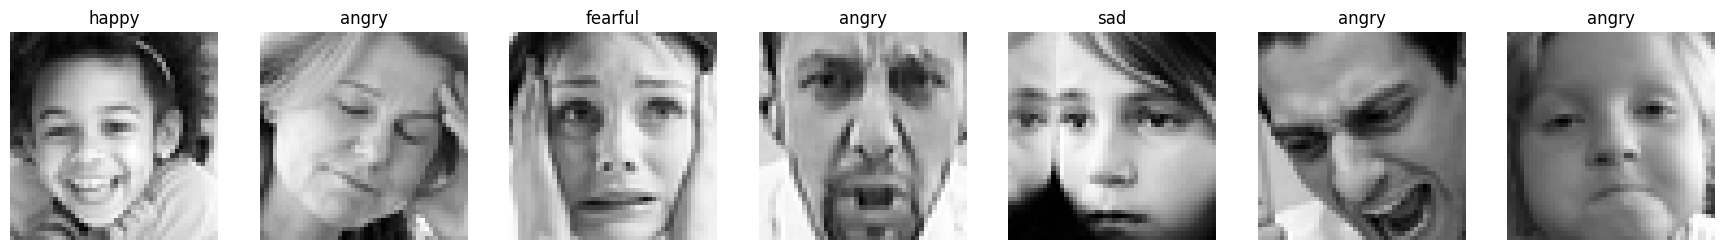

Image size (W x H): (48, 48)


In [37]:
# Visualizing sample images
train_dir = os.path.join(data_path, "train")

example_path = glob(os.path.join(data_path, "train", "*", "*.png"))
print("Total training images:", len(example_path))

# 7 Random Images (1 images from each Class)
fig, axes = plt.subplots(1, 7, figsize=(22,8))
for ax in axes:
    img_path = random.choice(example_path)
    label = img_path.split(os.sep)[-2]  
    img = Image.open(img_path).convert("L")  # grayscale
    ax.imshow(img, cmap="gray")
    ax.set_title(label)
    ax.axis("off")
plt.show()
print("Image size (W x H):", img.size)

In [38]:
#Transfor ->to tensor
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for better training
])

eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Train Dataset
train_dataset = datasets.ImageFolder(os.path.join(data_path, "train"), transform=None)
print(f"Train set size before augmentation and split : {len(train_dataset)}")

class_names = train_dataset.classes
y=np.array(train_dataset.targets)
idxs=np.arange(len(y))

#Stratified split (10% validation data)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(splitter.split(idxs, y))
# Train and Validation Dataset
full_train_aug = datasets.ImageFolder(os.path.join(data_path, "train"), transform=train_tf)
full_train_eval = datasets.ImageFolder(os.path.join(data_path, "train"), transform=eval_tf)

train_dataset = Subset(full_train_aug, train_idx) 
val_dataset   = Subset(full_train_eval, val_idx)    
# Test Dataset
test_dataset  = datasets.ImageFolder(os.path.join(data_path, "test"),  transform=eval_tf)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Data Loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Train set size before augmentation and split : 28709
Train set size: 25838
Validation set size: 2871
Test set size: 7178


In [39]:
class EmotionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionResNet, self).__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        # Modify first conv layer for 1 channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify last fc layer for num_classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionResNet(num_classes=len(class_names)).to(device)

c:\Users\Shreyaan\anaconda3\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Shreyaan\anaconda3\envs\dl_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Shreyaan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:07<00:00, 6.04MB/s]



In [43]:
def accuracy_from_logits(logits, y): # Computing Accuracy
 
    preds = logits.argmax(dim=1)              # class with highest logit = predicted label
    return (preds == y).float().mean().item() # mean of correct predictions
    
def run_epoch(model, loader, optimizer=None):
   
    is_train = optimizer is not None
    model.train(is_train)   # switch between train/eval mode
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
            optimizer.step()

        # Track statistics
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

In [44]:
EPOCHS = 100
LR = 1e-4  # Lower LR for fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5  # Increased patience
)

In [28]:
best_val_loss = float('inf')   # best score so far
patience = 5                   # early stopping patience
wait = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

t0_all = time.time()
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # Training epoch
    train_loss, train_acc = run_epoch(model, train_loader, optimizer=optimizer)
    # Validation epoch
    val_loss,   val_acc   = run_epoch(model, val_loader,   optimizer=None)

    # Save metrics
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

    # Scheduler update (on validation loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f} | "
          f"{time.time() - t0:.1f}s")

    # Early stopping + checkpoint
    if val_loss + 1e-6 < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_cnn.pt")   # save best model
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

print(f"Total training time: {time.time() - t0_all:.1f}s")

Epoch 01 | train loss 1.5556 acc 0.394 | val loss 1.5760 acc 0.392 | 13.0s
Epoch 02 | train loss 1.3412 acc 0.488 | val loss 1.3753 acc 0.477 | 13.6s
Epoch 03 | train loss 1.2724 acc 0.516 | val loss 1.4588 acc 0.392 | 13.9s
Epoch 04 | train loss 1.2294 acc 0.535 | val loss 1.2987 acc 0.511 | 13.9s
Epoch 05 | train loss 1.2006 acc 0.544 | val loss 1.2510 acc 0.536 | 13.5s
Epoch 06 | train loss 1.1690 acc 0.556 | val loss 1.3040 acc 0.514 | 13.8s
Epoch 07 | train loss 1.1567 acc 0.565 | val loss 1.1868 acc 0.547 | 13.9s
Epoch 08 | train loss 1.1300 acc 0.574 | val loss 1.1827 acc 0.568 | 14.0s
Epoch 09 | train loss 1.1106 acc 0.580 | val loss 1.1712 acc 0.550 | 13.0s
Epoch 10 | train loss 1.0966 acc 0.589 | val loss 1.1450 acc 0.568 | 13.0s
Epoch 11 | train loss 1.0844 acc 0.590 | val loss 1.1240 acc 0.575 | 13.3s
Epoch 12 | train loss 1.0714 acc 0.598 | val loss 1.1231 acc 0.576 | 13.3s
Epoch 13 | train loss 1.0549 acc 0.604 | val loss 1.1499 acc 0.560 | 13.0s
Epoch 14 | train loss 1.0

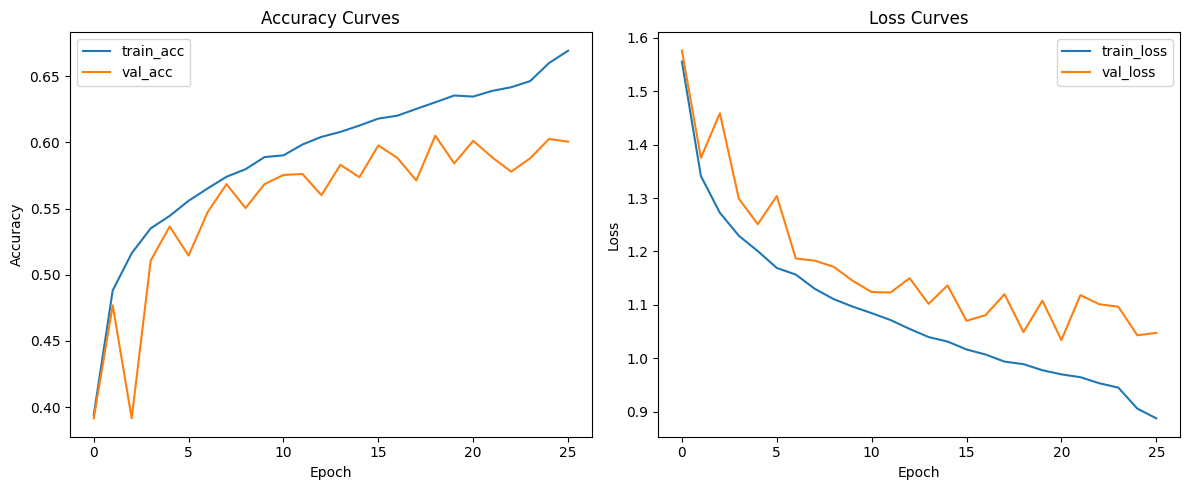

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Curves
axes[0].plot(history["train_acc"], label="train_acc")
axes[0].plot(history["val_acc"],   label="val_acc")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy Curves")
axes[0].legend()

#  Loss Curves 
axes[1].plot(history["train_loss"], label="train_loss")
axes[1].plot(history["val_loss"],   label="val_loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss Curves")
axes[1].legend()

plt.tight_layout()
plt.show()

In [30]:
best_model = CNNEmotion(num_classes=len(class_names)).to(device)
best_model.load_state_dict(torch.load("best_cnn.pt", map_location=device))
best_model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = best_model(x)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_true.extend(y.cpu().numpy().tolist())

test_acc = (np.array(all_preds) == np.array(all_true)).mean()

In [31]:
# Test accuracy
print("Test accuracy:", test_acc)
# Classification Report
print("\nClassification report:\n")
print(classification_report(all_true, all_preds, target_names=class_names))

Test accuracy: 0.6177208135971023

Classification report:

              precision    recall  f1-score   support

       angry       0.55      0.53      0.54       958
   disgusted       0.66      0.26      0.37       111
     fearful       0.57      0.25      0.34      1024
       happy       0.84      0.82      0.83      1774
     neutral       0.49      0.73      0.59      1233
         sad       0.49      0.52      0.50      1247
   surprised       0.75      0.76      0.75       831

    accuracy                           0.62      7178
   macro avg       0.62      0.55      0.56      7178
weighted avg       0.63      0.62      0.61      7178



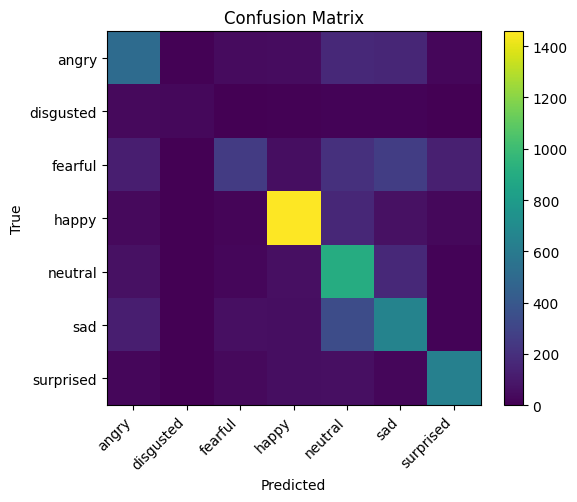

In [32]:
# Confusion Matrix 
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
def show_random_test_predictions(model, dataset, n=8):
    idxs = random.sample(range(len(dataset)), n)
    imgs, labels = zip(*[dataset[i] for i in idxs])   # list of (C,H,W) tensors + int labels

    batch = torch.stack(imgs).to(device)              # [n,1,48,48]
    labels_t = torch.tensor(labels).to(device)

    with torch.no_grad():
        logits = model(batch)
        probs  = F.softmax(logits, dim=1)
        preds  = probs.argmax(dim=1)

    # plot
    rows, cols = 2, n // 2 if n % 2 == 0 else (n // 3 + 1)
    cols = n // rows + (n % rows > 0)
    plt.figure(figsize=(3*cols, 3*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        img = imgs[i].squeeze(0).cpu().numpy()       # (48,48)
        plt.imshow(img, cmap="gray")
        true_label = class_names[labels[i]]  # Fixed: use class_names instead of classes
        pred_label = class_names[preds[i].item()]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=10)
        plt.axis("off")
    plt.suptitle("Random Test Images: Predictions vs Ground Truth", fontsize=14)
    plt.tight_layout()
    plt.show()

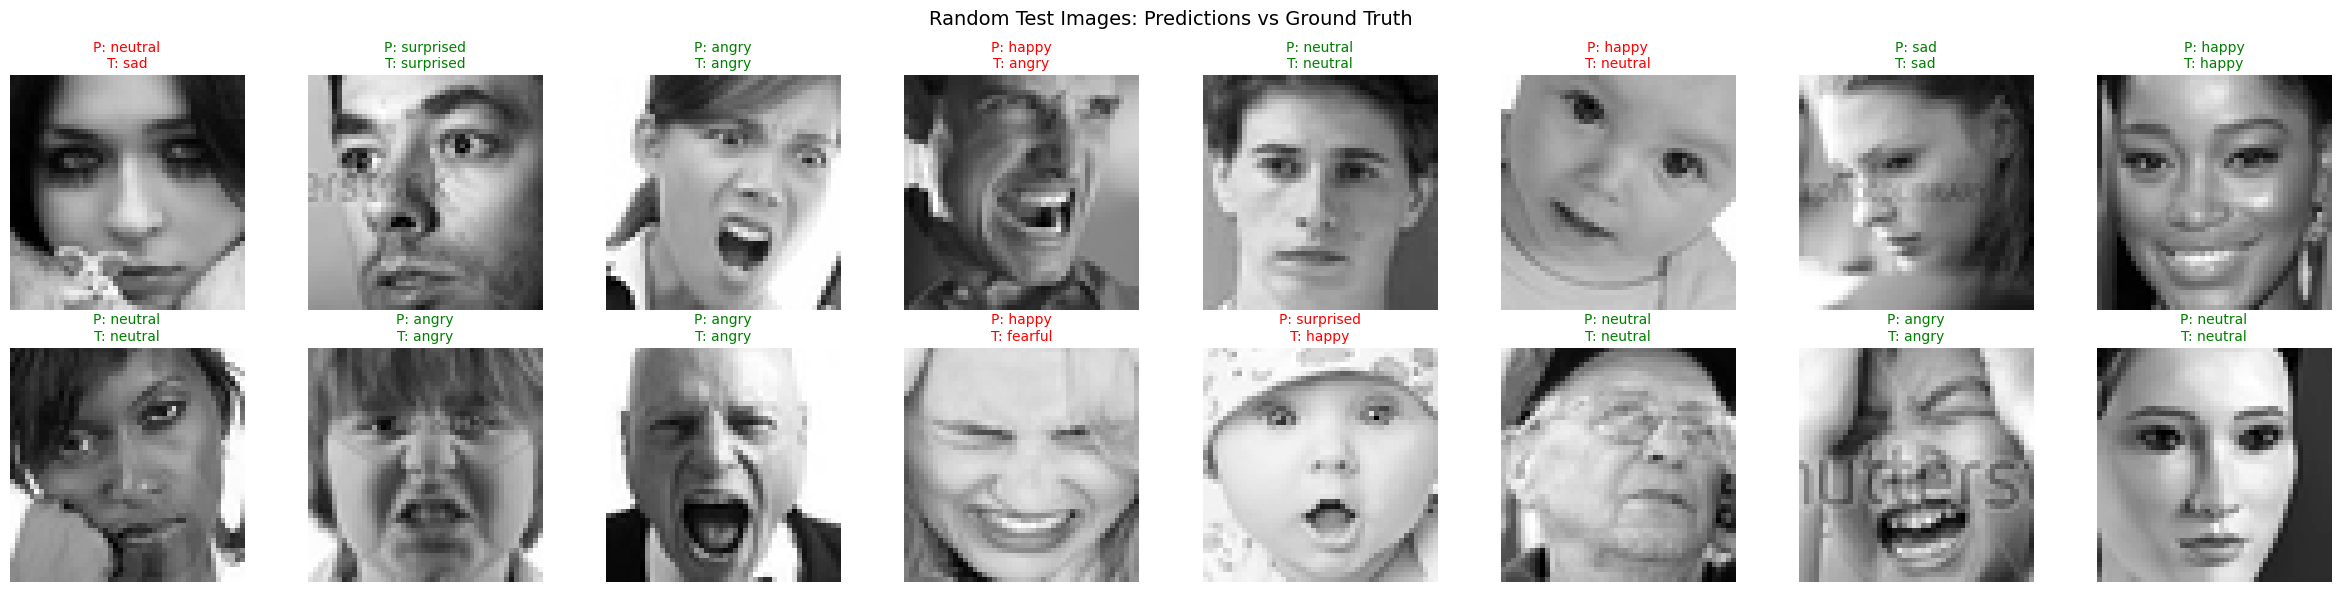

In [34]:
show_random_test_predictions(best_model, test_dataset, n=16)